This notebook shows how to add layers to calculate the macornutrient content of an image  to a trained assembled resnet model
Then also shows how to run a prediction with this model and convert to Tensorflow serving. 

In [ ]:
%cd ../assembled-cnn

In [3]:
import sys
sys.path.append('.')

In [4]:
import tensorflow as tf
tf.__version__

/home/jwf5/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jwf5/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jwf5/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jwf5/venv/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: P

'1.14.0'

# Import

In [21]:
from functions import model_fns
from preprocessing import imagenet_preprocessing
from utils.data_util import *
from utils.hook_utils import *
from metric import ece_metric
from nets import hparams_config
from nets.optimizer_setting import *
from official.utils.flags import core as flags_core
from official.utils.logs import hooks_helper
from official.utils.logs import logger
from official.utils.misc import model_helpers
from utils import checkpoint_utils
from utils import data_util
from utils import export_utils
from utils.hook_utils import *
from utils import config_utils
from functions import data_config, model_fns, input_fns
from nets import blocks
from losses import cls_losses
from functions import input_fns, data_config, model_fns
from nets import run_loop_classification
from official.utils.flags import core as flags_core
from official.utils.logs import logger
from utils import log_utils
from utils import config_utils
from absl import app as absl_app
from metric import recall_metric
from absl import flags
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
import logging
def define_log_level():
  tf_logger = logging.getLogger('tensorflow')
  tf_logger.propagate = False
  handler = logging.StreamHandler(sys.stdout)
  formatter = logging.Formatter("%(asctime)s.%(msecs).3d %(levelname).1s: %(message)s", datefmt="%Y-%m-%d %H:%M:%S")
  handler.setFormatter(formatter)
  tf_logger.handlers = [handler]
  tf_logger.setLevel(tf.logging.INFO)
define_log_level()

In [ ]:
# Run a macronutrient prediction on images in the directory
directory="test/"
export_utils.run_prediction('train/m2/export_test/channels_last/binary_input/1596301496', directory, False)

In [ ]:
# Run a prediction on images in the directory and save the model with the added layers, 
export_utils.run_prediction('train/m2/export_test/channels_last/binary_input/1596301496', directory,True)

In [ ]:
# The code in the following cells runs the local dataset through the model and performs tests

In [16]:
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from math import sqrt
import numpy as np
def getFoodResults(filename, food):
    import imp
    imp.reload(export_utils)
    # tf.enable_eager_execution() 
    results = export_utils.run_prediction('train/m2/export_test/channels_last/binary_input/1596301496', filename)


    #Macornutrient data
    macro_df = pd.read_csv('../FOODX-251_Dataset/macro_data_foodX251.csv')
    df = pd.read_csv('../FOODX-251_Dataset/class_list.csv')
    df["label"] = df.index
    df = df.merge(macro_df, how='left', on='label', sort=False)

    

    prediction = pd.DataFrame()   
    
    meanDataframe = pd.DataFrame(columns=['Energy', 'Protein', 'Fat', 'Carbohydrate'])
#     meanDataframe = meanDataframe.append([[152.2, 8.2, 7.6, 15.6]] * 9)
    
    for i in range(9):
        meanDataframe.loc[i] = [152.2, 8.2, 7.6, 15.6]
    
        
    pred1 = prediction.append([df[df['food'] == food]] * 9, ignore_index = True)
    print(pred1)


    RSMEArray = []
    RSMEArray.append( np.sqrt(mean_squared_error(pred1['Energy'], results['Energy'])))
    RSMEArray.append( np.sqrt(mean_squared_error(pred1['Protein'],results['Protein'])))
    RSMEArray.append( np.sqrt(mean_squared_error(pred1['Fat'], results['Fat'])))
    RSMEArray.append( np.sqrt(mean_squared_error(pred1['Carbohydrate'], results['Carbohydrate'])))
    print(food)
    print("RSME for Energy: "  + str(RSMEArray[0]))
    print("RSME for Protein: "  + str(RSMEArray[1])) 
    print("RSME for Fat: "  + str(RSMEArray[2]))
    print("RSME for Carbohydrate: "  + str(RSMEArray[3]))
    print(results)
    results['Food Index'] = results['Food Index'].str[0]
    to_append = [pred1.iloc[0]["food"], pred1.iloc[0]["label"], pred1.iloc[0]["Energy"], pred1.iloc[0]["Fat"], pred1.iloc[0]["Protein"], pred1.iloc[0]["Carbohydrate"]]
    a_series = pd.Series(to_append, index = ['Predicted food', 'Food Index', 'Energy'    ,'Fat','Protein' , 'Carbohydrate'])
    df_length = len(results)
  
    #print(results.append(a_series, ignore_index=True).round(2).to_latex())
    return results.append(a_series, ignore_index=True).round(2)
    
    
def getUnknownFoodResults(filename, food, energy, fat, protein, carbohydrate):
    import imp
    imp.reload(export_utils)
    results = export_utils.run_prediction('train/m2/export_test/channels_last/binary_input/1596301496', filename)

    #Macornutrient data
    macro_df = pd.read_csv('../FOODX-251_Dataset/macro_data_foodX251.csv')
    df = pd.read_csv('../FOODX-251_Dataset/class_list.csv')
    df["label"] = df.index
    df = df.merge(macro_df, how='left', on='label', sort=False)
    
    data = np.array([['','food', 'Energy','Protein', 'Fat', 'Carbohydrate'],
                ['1',food, energy,fat, protein, carbohydrate]]
                )
    df = pd.DataFrame(data=data[1:,1:],
                  index=data[1:,0],
                  columns=data[0,1:])
    
    prediction = pd.DataFrame()   
    
    meanDataframe = pd.DataFrame(columns=['Energy', 'Protein', 'Fat', 'Carbohydrate'])
    
    for i in range(9):
        meanDataframe.loc[i] = [152.2, 8.2, 7.6, 15.6]
    
    pred = prediction.append([df[df['food'] == food]] * 9, ignore_index = True)
    print(pred)
   

    RSMEArray = []
    RSMEArray.append( np.sqrt(mean_squared_error(pred['Energy'], results['Energy'])))
    RSMEArray.append( np.sqrt(mean_squared_error(pred['Protein'],results['Protein'])))
    RSMEArray.append( np.sqrt(mean_squared_error(pred['Fat'], results['Fat'])))
    RSMEArray.append( np.sqrt(mean_squared_error(pred['Carbohydrate'], results['Carbohydrate'])))
    print(food)
    print("RSME for Energy: "  + str(RSMEArray[0]))
    print("RSME for Protein: "  + str(RSMEArray[1])) 
    print("RSME for Fat: "  + str(RSMEArray[2]))
    print("RSME for Carbohydrate: "  + str(RSMEArray[3]))
    print(results)
    results['Food Index'] = results['Food Index'].str[0]
    to_append = [pred.iloc[0]["food"], pred.iloc[0]["Energy"], pred.iloc[0]["Fat"], pred.iloc[0]["Protein"], pred.iloc[0]["Carbohydrate"]]
    a_series = pd.Series(to_append, index = ['Predicted food', 'Energy',   'Fat' , 'Protein' , 'Carbohydrate'])
    df_length = len(results)
    results.drop("Food Index", inplace=True, axis=1)
    results['Carbohydrate'] = results['Carbohydrate'].astype(float).round(2)
    results['Fat'] = results['Fat'].astype(float).round(2)
    results['Protein'] = results['Protein'].astype(float).round(2)
    results['Energy'] = results['Energy'].astype(float).round(2)
    print(results.append(a_series, ignore_index=True).round(2).to_latex())
    print()

In [222]:
a = getFoodResults('../FOODX-251_Dataset/imgs/ham_sandwich', 'ham_sandwich')

2020-10-23 03:39:53.737 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:32<04:21, 32.66s/it]

 33%|███▎      | 3/9 [00:32<02:17, 22.89s/it]

 56%|█████▌    | 5/9 [00:32<01:04, 16.04s/it]

 78%|███████▊  | 7/9 [00:33<00:22, 11.25s/it]

100%|██████████| 9/9 [00:33<00:00,  3.70s/it]


           food  label  Energy  Protein   Fat  Carbohydrate
0  ham_sandwich    106   241.0    12.07  9.94         24.99
1  ham_sandwich    106   241.0    12.07  9.94         24.99
2  ham_sandwich    106   241.0    12.07  9.94         24.99
3  ham_sandwich    106   241.0    12.07  9.94         24.99
4  ham_sandwich    106   241.0    12.07  9.94         24.99
5  ham_sandwich    106   241.0    12.07  9.94         24.99
6  ham_sandwich    106   241.0    12.07  9.94         24.99
7  ham_sandwich    106   241.0    12.07  9.94         24.99
8  ham_sandwich    106   241.0    12.07  9.94         24.99
ham_sandwich
RSME for Energy: 22.41129869635365
RSME for Protein: 2.3953320922527834
RSME for Fat: 0.9388394060689375
RSME for Carbohydrate: 5.084339169785406
  Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0   ham_sandwich      [106]  208.358795   8.472497   8.716817     23.919933
1   ham_sandwich      [106]  247.779068  10.492682   9.663382     28.055527
2   ham_sandw

In [223]:
b = getFoodResults('../FOODX-251_Dataset/imgs/falafel', 'falafel')

2020-10-23 03:41:03.480 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:33<04:30, 33.80s/it]

 33%|███▎      | 3/9 [00:33<02:22, 23.68s/it]

 56%|█████▌    | 5/9 [00:34<01:06, 16.60s/it]

 78%|███████▊  | 7/9 [00:34<00:23, 11.64s/it]

100%|██████████| 9/9 [00:34<00:00,  3.82s/it]


      food  label  Energy  Protein    Fat  Carbohydrate
0  falafel     53   505.0     8.33  40.54         29.32
1  falafel     53   505.0     8.33  40.54         29.32
2  falafel     53   505.0     8.33  40.54         29.32
3  falafel     53   505.0     8.33  40.54         29.32
4  falafel     53   505.0     8.33  40.54         29.32
5  falafel     53   505.0     8.33  40.54         29.32
6  falafel     53   505.0     8.33  40.54         29.32
7  falafel     53   505.0     8.33  40.54         29.32
8  falafel     53   505.0     8.33  40.54         29.32
falafel
RSME for Energy: 146.5711925917881
RSME for Protein: 3.3702212088096437
RSME for Fat: 15.274226502780031
RSME for Carbohydrate: 7.658733200508789
  Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0        falafel       [53]  321.812195  22.191978  13.857663     16.884670
1        falafel       [53]  334.329163  20.975355  10.781026     26.464664
2        falafel       [53]  388.955200  28.856815  11.114

In [224]:
c = getFoodResults('../FOODX-251_Dataset/imgs/burger', 'hamburger')

2020-10-23 03:42:15.303 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:33<04:28, 33.61s/it]

 33%|███▎      | 3/9 [00:33<02:21, 23.55s/it]

 56%|█████▌    | 5/9 [00:33<01:06, 16.51s/it]

 78%|███████▊  | 7/9 [00:34<00:23, 11.58s/it]

100%|██████████| 9/9 [00:34<00:00,  3.80s/it]


        food  label  Energy  Protein    Fat  Carbohydrate
0  hamburger    164   297.0    16.52  12.01          31.5
1  hamburger    164   297.0    16.52  12.01          31.5
2  hamburger    164   297.0    16.52  12.01          31.5
3  hamburger    164   297.0    16.52  12.01          31.5
4  hamburger    164   297.0    16.52  12.01          31.5
5  hamburger    164   297.0    16.52  12.01          31.5
6  hamburger    164   297.0    16.52  12.01          31.5
7  hamburger    164   297.0    16.52  12.01          31.5
8  hamburger    164   297.0    16.52  12.01          31.5
hamburger
RSME for Energy: 71.62524345007432
RSME for Protein: 4.382389246524187
RSME for Fat: 2.4675152556377378
RSME for Carbohydrate: 9.089521259559309
  Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0      hamburger      [164]  265.806549  12.146401  14.793096     24.568947
1      hamburger      [164]  265.287720  11.028752  15.244378     26.626032
2      hamburger      [164]  274.8732

In [225]:
d = getFoodResults('../FOODX-251_Dataset/imgs/sushi', 'sushi')

2020-10-23 03:43:26.772 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:33<04:31, 33.98s/it]

 33%|███▎      | 3/9 [00:34<02:22, 23.81s/it]

 56%|█████▌    | 5/9 [00:34<01:06, 16.69s/it]

 78%|███████▊  | 7/9 [00:34<00:23, 11.71s/it]

100%|██████████| 9/9 [00:34<00:00,  3.84s/it]


    food  label  Energy  Protein   Fat  Carbohydrate
0  sushi     37    93.0     2.92  0.67         18.42
1  sushi     37    93.0     2.92  0.67         18.42
2  sushi     37    93.0     2.92  0.67         18.42
3  sushi     37    93.0     2.92  0.67         18.42
4  sushi     37    93.0     2.92  0.67         18.42
5  sushi     37    93.0     2.92  0.67         18.42
6  sushi     37    93.0     2.92  0.67         18.42
7  sushi     37    93.0     2.92  0.67         18.42
8  sushi     37    93.0     2.92  0.67         18.42
sushi
RSME for Energy: 59.64115526547087
RSME for Protein: 7.198840477400762
RSME for Fat: 6.1777538908929674
RSME for Carbohydrate: 7.720488503734964
  Predicted food Food Index      Energy       Fat    Protein  Carbohydrate
0        sashimi        [9]  172.455490  9.725698  13.183526      7.264692
1          sushi       [37]  186.673325  8.395832  10.332894     17.183424
2        sashimi        [9]  151.643005  7.889493  12.224908      7.131097
3          sushi   

In [226]:
e = getFoodResults('../FOODX-251_Dataset/imgs/shashimi', 'sashimi')

2020-10-23 03:44:38.915 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:33<04:30, 33.87s/it]

 33%|███▎      | 3/9 [00:34<02:22, 23.74s/it]

 56%|█████▌    | 5/9 [00:34<01:06, 16.64s/it]

 78%|███████▊  | 7/9 [00:34<00:23, 11.67s/it]

100%|██████████| 9/9 [00:34<00:00,  3.84s/it]


      food  label  Energy  Protein  Fat  Carbohydrate
0  sashimi      9   159.0    14.73  9.3           3.1
1  sashimi      9   159.0    14.73  9.3           3.1
2  sashimi      9   159.0    14.73  9.3           3.1
3  sashimi      9   159.0    14.73  9.3           3.1
4  sashimi      9   159.0    14.73  9.3           3.1
5  sashimi      9   159.0    14.73  9.3           3.1
6  sashimi      9   159.0    14.73  9.3           3.1
7  sashimi      9   159.0    14.73  9.3           3.1
8  sashimi      9   159.0    14.73  9.3           3.1
sashimi
RSME for Energy: 24.122768131914096
RSME for Protein: 3.857783644275084
RSME for Fat: 2.1211672701810564
RSME for Carbohydrate: 7.9939827818733455
  Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0        rugulah      [238]  215.599854  11.479668   8.292061     19.831612
1          sushi       [37]  143.016922   5.881087   8.862202     13.302808
2        sashimi        [9]  155.852219   8.060797  10.329657     10.018407
3

In [227]:
f = getFoodResults('../FOODX-251_Dataset/imgs/egg', 'scrambled_eggs')

2020-10-23 03:45:51.330 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:34<04:38, 34.76s/it]

 33%|███▎      | 3/9 [00:34<02:26, 24.36s/it]

 56%|█████▌    | 5/9 [00:35<01:08, 17.07s/it]

 78%|███████▊  | 7/9 [00:35<00:23, 11.98s/it]

100%|██████████| 9/9 [00:35<00:00,  3.93s/it]


             food  label  Energy  Protein    Fat  Carbohydrate
0  scrambled_eggs     34   149.0     9.99  10.98          1.61
1  scrambled_eggs     34   149.0     9.99  10.98          1.61
2  scrambled_eggs     34   149.0     9.99  10.98          1.61
3  scrambled_eggs     34   149.0     9.99  10.98          1.61
4  scrambled_eggs     34   149.0     9.99  10.98          1.61
5  scrambled_eggs     34   149.0     9.99  10.98          1.61
6  scrambled_eggs     34   149.0     9.99  10.98          1.61
7  scrambled_eggs     34   149.0     9.99  10.98          1.61
8  scrambled_eggs     34   149.0     9.99  10.98          1.61
scrambled_eggs
RSME for Energy: 55.58946376733316
RSME for Protein: 2.2301717718802228
RSME for Fat: 1.304676430100823
RSME for Carbohydrate: 18.605529600339676
        Predicted food Food Index      Energy        Fat   Protein  \
0       scrambled_eggs       [34]  168.493271   9.606861  8.559252   
1  macaroni_and_cheese       [79]  196.659775   9.684103  8.541564   

In [228]:
g = getFoodResults('../FOODX-251_Dataset/imgs/rissoto', 'risotto')

2020-10-23 03:47:05.003 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:34<04:38, 34.76s/it]

 33%|███▎      | 3/9 [00:34<02:26, 24.36s/it]

 56%|█████▌    | 5/9 [00:35<01:08, 17.07s/it]

 78%|███████▊  | 7/9 [00:35<00:23, 11.98s/it]

100%|██████████| 9/9 [00:35<00:00,  3.94s/it]


      food  label  Energy  Protein   Fat  Carbohydrate
0  risotto     30   166.0     5.16  6.98         20.02
1  risotto     30   166.0     5.16  6.98         20.02
2  risotto     30   166.0     5.16  6.98         20.02
3  risotto     30   166.0     5.16  6.98         20.02
4  risotto     30   166.0     5.16  6.98         20.02
5  risotto     30   166.0     5.16  6.98         20.02
6  risotto     30   166.0     5.16  6.98         20.02
7  risotto     30   166.0     5.16  6.98         20.02
8  risotto     30   166.0     5.16  6.98         20.02
risotto
RSME for Energy: 18.550743150790055
RSME for Protein: 3.339132540321224
RSME for Fat: 1.8763095218715786
RSME for Carbohydrate: 3.1841516145404665
   Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0    ham_and_eggs      [176]  181.285477   8.528977   7.857415     18.076075
1    ham_and_eggs      [176]  177.210724   8.285473   7.482528     18.121025
2         risotto       [30]  169.041779   7.809450   7.213391  

In [229]:
h = getFoodResults('../FOODX-251_Dataset/imgs/samosa', 'samosa')

2020-10-23 03:48:18.730 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:34<04:38, 34.84s/it]

 33%|███▎      | 3/9 [00:34<02:26, 24.41s/it]

 56%|█████▌    | 5/9 [00:35<01:08, 17.11s/it]

 78%|███████▊  | 7/9 [00:35<00:23, 12.00s/it]

100%|██████████| 9/9 [00:35<00:00,  3.94s/it]


     food  label  Energy  Protein    Fat  Carbohydrate
0  samosa      4   308.0     4.66  17.86         32.21
1  samosa      4   308.0     4.66  17.86         32.21
2  samosa      4   308.0     4.66  17.86         32.21
3  samosa      4   308.0     4.66  17.86         32.21
4  samosa      4   308.0     4.66  17.86         32.21
5  samosa      4   308.0     4.66  17.86         32.21
6  samosa      4   308.0     4.66  17.86         32.21
7  samosa      4   308.0     4.66  17.86         32.21
8  samosa      4   308.0     4.66  17.86         32.21
samosa
RSME for Energy: 29.38250924382374
RSME for Protein: 3.4436210621113728
RSME for Fat: 4.29740211913693
RSME for Carbohydrate: 4.246800089207988
   Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0    ham_sandwich      [106]  250.597961  12.391251  11.043151     23.318502
1          samosa        [4]  295.987000  15.256932   6.371481     33.250046
2  apple_turnover      [244]  296.662994  13.631498   6.595973     3

In [428]:
i = getFoodResults('../FOODX-251_Dataset/imgs/mac', 'macaroni_and_cheese')

2020-10-29 20:54:15.406 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:34<04:39, 34.92s/it]

 33%|███▎      | 3/9 [00:35<02:26, 24.46s/it]

 56%|█████▌    | 5/9 [00:35<01:08, 17.15s/it]

 78%|███████▊  | 7/9 [00:35<00:24, 12.02s/it]

100%|██████████| 9/9 [00:35<00:00,  3.95s/it]


                  food  label  Energy  Protein    Fat  Carbohydrate
0  macaroni_and_cheese     79   220.0     8.58  10.22         23.17
1  macaroni_and_cheese     79   220.0     8.58  10.22         23.17
2  macaroni_and_cheese     79   220.0     8.58  10.22         23.17
3  macaroni_and_cheese     79   220.0     8.58  10.22         23.17
4  macaroni_and_cheese     79   220.0     8.58  10.22         23.17
5  macaroni_and_cheese     79   220.0     8.58  10.22         23.17
6  macaroni_and_cheese     79   220.0     8.58  10.22         23.17
7  macaroni_and_cheese     79   220.0     8.58  10.22         23.17
8  macaroni_and_cheese     79   220.0     8.58  10.22         23.17
macaroni_and_cheese
RSME for Energy: 24.618946691925334
RSME for Protein: 1.6243089372251804
RSME for Fat: 3.2964443705386737
RSME for Carbohydrate: 6.064959708480596
        Predicted food Food Index      Energy       Fat    Protein  \
0  macaroni_and_cheese       [79]  229.993561  8.557879   9.199633   
1            

In [429]:
j = getFoodResults('../FOODX-251_Dataset/imgs/curry', 'chicken_curry')

2020-10-29 20:55:30.689 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:35<04:43, 35.39s/it]

 33%|███▎      | 3/9 [00:35<02:28, 24.79s/it]

 56%|█████▌    | 5/9 [00:35<01:09, 17.38s/it]

 78%|███████▊  | 7/9 [00:35<00:24, 12.19s/it]

100%|██████████| 9/9 [00:35<00:00,  4.00s/it]


            food  label  Energy  Protein   Fat  Carbohydrate
0  chicken_curry     92    82.0     6.31  3.52          6.67
1  chicken_curry     92    82.0     6.31  3.52          6.67
2  chicken_curry     92    82.0     6.31  3.52          6.67
3  chicken_curry     92    82.0     6.31  3.52          6.67
4  chicken_curry     92    82.0     6.31  3.52          6.67
5  chicken_curry     92    82.0     6.31  3.52          6.67
6  chicken_curry     92    82.0     6.31  3.52          6.67
7  chicken_curry     92    82.0     6.31  3.52          6.67
8  chicken_curry     92    82.0     6.31  3.52          6.67
chicken_curry
RSME for Energy: 25.794891721685822
RSME for Protein: 1.4012758940501624
RSME for Fat: 1.42134877000309
RSME for Carbohydrate: 2.0113242132047775
      Predicted food Food Index      Energy       Fat   Protein  Carbohydrate
0     lobster_bisque      [200]   94.790405  4.385965  7.597261      6.018479
1     lobster_bisque      [200]  112.395088  5.117385  8.925407      7.510

In [538]:

def getRangeAngle(start, df, macro):
    temp = []
    for z in range(start, start + 3):
        temp.append(df.iloc[z][macro])
    sum = 0
    mean = 0
    for z in range(len(temp)): 
        mean += temp[z]
    mean = mean/len(temp)
    for z in range(len(temp)):
        sum+= (abs((mean - temp[z])))
    sum = sum/(len(temp)-1)
    return sum
    
def getAverageRangeAngle(dfArray, start, macro):
    sum = 0; 
    for z in range(10):
        sum += getRangeAngle(start, dfArray[z], macro)
    return sum/(10)

def getRangeBackground(start, df, macro):
    temp = []
    for z in range(start, start + 6, 3):
        temp.append(df.iloc[z][macro])
    sum = 0
    mean = 0
    for z in range(len(temp)): 
        mean += temp[z]
    mean = mean/len(temp)
    for z in range(len(temp)):
        sum+= (abs(mean - temp[z]))
    sum = sum/(len(temp)-1)
    return sum
    
def getAverageRangebackground(dfArray, start, macro):
    sum = 0; 
    for z in range(10):
        sum += getRangeBackground(start, dfArray[z], macro)
    return sum/(10)

dfA = [a, b, c, d, e, f, g, h, i, j]


print(getAverageRangeAngle(dfA, 0, 'Energy'))
print(getAverageRangeAngle(dfA, 3, 'Energy'))
print(getAverageRangeAngle(dfA, 6, 'Energy'))

print(getAverageRangebackground(dfA, 0, 'Energy'))
print(getAverageRangebackground(dfA, 1, 'Energy'))
print(getAverageRangebackground(dfA, 2, 'Energy'))
print()
print(getAverageRangeAngle(dfA, 0, 'Fat'))
print(getAverageRangeAngle(dfA, 3, 'Fat'))
print(getAverageRangeAngle(dfA, 6, 'Fat'))

print(getAverageRangebackground(dfA, 0, 'Fat'))
print(getAverageRangebackground(dfA, 1, 'Fat'))
print(getAverageRangebackground(dfA, 2, 'Fat'))
print()
print(getAverageRangeAngle(dfA, 0, 'Protein'))
print(getAverageRangeAngle(dfA, 3, 'Protein'))
print(getAverageRangeAngle(dfA, 6, 'Protein'))

print(getAverageRangebackground(dfA, 0, 'Protein'))
print(getAverageRangebackground(dfA, 1, 'Protein'))
print(getAverageRangebackground(dfA, 2, 'Protein'))
print()
print(getAverageRangeAngle(dfA, 0, 'Carbohydrate'))
print(getAverageRangeAngle(dfA, 3, 'Carbohydrate'))
print(getAverageRangeAngle(dfA, 6, 'Carbohydrate'))

print(getAverageRangebackground(dfA, 0, 'Carbohydrate'))
print(getAverageRangebackground(dfA, 1, 'Carbohydrate'))
print(getAverageRangebackground(dfA, 2, 'Carbohydrate'))
        

26.317
23.322999999999997
31.685333333333336
28.446000000000005
41.39
26.292

1.6706666666666667
1.6446666666666665
1.8056666666666665
2.2060000000000004
3.2370000000000005
1.41

1.4443333333333335
1.7710000000000004
1.739
2.2369999999999997
2.9260000000000006
1.9690000000000005

4.644333333333334
3.023333333333333
5.066000000000001
5.848000000000001
4.919
4.816999999999999


In [539]:
# for i in range(10):
#     dfA[i][9] = None
# result = pd.concat(dfA)
# a.drop(index = 9, axis = 0)
# count = 9
result = pd.concat([a, b, c, d , e , f, g ,h ,i ,j], sort=False)
# result = result.drop(9, axis = 0)
j    

,Predicted food,Food Index,Energy,Fat,Protein,Carbohydrate
0,lobster_bisque,200,94.79,4.39,7.60,6.02
1,lobster_bisque,200,112.40,5.12,8.93,7.51
2,lobster_bisque,200,73.86,3.42,6.30,4.25
3,lobster_bisque,200,110.89,5.39,7.27,8.19
4,lobster_bisque,200,79.85,3.69,6.89,4.54
5,hot_and_sour_soup,186,96.86,4.02,6.96,8.10
6,lobster_bisque,200,134.86,6.26,8.49,11.03
7,lobster_bisque,200,110.01,5.30,7.57,7.89
8,lobster_bisque,200,95.98,4.20,7.39,6.97
9,chicken_curry,92,82.00,3.52,6.31,6.67


In [514]:
clean = result.loc[[0, 1, 2]]
semiclean = result.loc[[3, 4, 5]]
messy = result.loc[[6, 7, 8]]
counter = 9
second = 0
actual = pd.DataFrame()
for x in range(10):
    actual = actual.append(result.iloc[[9* (x +1) + second]])
    second+=1
cleanA = pd.DataFrame()
for x in range(10):
    cleanA = cleanA.append(actual.loc[actual['Predicted food'] == actual['Predicted food'].iloc[x]])
for x in range(10):
    cleanA = cleanA.append(actual.loc[actual['Predicted food'] == actual['Predicted food'].iloc[x]])
for x in range(10):
    cleanA = cleanA.append(actual.loc[actual['Predicted food'] == actual['Predicted food'].iloc[x]])
cleanA

,Predicted food,Food Index,Energy,Fat,Protein,Carbohydrate,9
9,ham_sandwich,106,241.0,9.94,12.07,24.99,None
9,falafel,53,505.0,40.54,8.33,29.32,None
9,hamburger,164,297.0,12.01,16.52,31.50,None
9,sushi,37,93.0,0.67,2.92,18.42,None
9,sashimi,9,159.0,9.30,14.73,3.10,None
9,scrambled_eggs,34,149.0,10.98,9.99,1.61,None
9,risotto,30,166.0,6.98,5.16,20.02,None
9,samosa,4,308.0,17.86,4.66,32.21,None
9,macaroni_and_cheese,79,220.0,10.22,8.58,23.17,NaN
9,chicken_curry,92,82.0,3.52,6.31,6.67,NaN


In [515]:
above = result.loc[[0, 3, 6]]
ninety = result.loc[[1, 4, 7]]
Side = result.loc[[2, 5, 8]]

,Predicted food,Food Index,Energy,Fat,Protein,Carbohydrate,9
9,ham_sandwich,106,241.0,9.94,12.07,24.99,None


In [520]:
def RSME(results, actual):    #Macornutrient data
    macro_df = pd.read_csv('../FOODX-251_Dataset/macro_data_foodX251.csv')
    df = pd.read_csv('../FOODX-251_Dataset/class_list.csv')
    df["label"] = df.index
    df = df.merge(macro_df, how='left', on='label', sort=False)
    prediction = pd.DataFrame()
    pred = pd.DataFrame()
    counter = 9
    for x in range(9):
        bbb = (x+1) * counter
        pred.append(result.iloc[[bbb]])
#         print(pred.append([df[df['food'] == result.iloc[[(x+1) * counter]]]], ignore_index = True))
    print(pred)
    RSMEArray = []
    RSMEArray.append( np.sqrt(mean_squared_error(actual['Energy'], results['Energy'])))
    RSMEArray.append( np.sqrt(mean_squared_error(actual['Protein'],results['Protein'])))
    RSMEArray.append( np.sqrt(mean_squared_error(actual['Fat'], results['Fat'])))
    RSMEArray.append( np.sqrt(mean_squared_error(actual['Carbohydrate'], results['Carbohydrate'])))
    return RSMEArray
print(RSME(clean, cleanA))
print(RSME(semiclean, cleanA))
print(RSME(messy, cleanA))

print(RSME(above, cleanA))
print(RSME(ninety, cleanA))
print(RSME(Side, cleanA))

Empty DataFrame
Columns: []
Index: []
[63.46621006488414, 4.139211680179372, 6.283490006888423, 8.810344298985521]
Empty DataFrame
Columns: []
Index: []
[49.571827012259014, 3.077937621200274, 4.512570221060277, 5.480648988334623]
Empty DataFrame
Columns: []
Index: []
[67.540231294639, 3.750308876168291, 6.000439983867849, 10.20220825769271]
Empty DataFrame
Columns: []
Index: []
[63.414056065407664, 3.8565351461296618, 5.688270973386084, 8.01109751116121]
Empty DataFrame
Columns: []
Index: []
[60.9983141843554, 3.3881887983601704, 5.9898951020308635, 7.078873968836192]
Empty DataFrame
Columns: []
Index: []
[57.488014895860395, 3.7840326813246916, 5.255049635033589, 9.8720106023714]


In [411]:
# getRSMEAngle(0, dfA )
# dfA[0][0]
dfA

[  Predicted food  Food Index  Energy    Fat  Protein  Carbohydrate     9
 0   ham_sandwich         106  208.36   8.47     8.72         23.92  None
 1   ham_sandwich         106  247.78  10.49     9.66         28.06  None
 2   ham_sandwich         106  246.78  11.33    11.94         23.66  None
 3   ham_sandwich         106  226.34   9.58     8.64         26.08  None
 4   ham_sandwich         106  239.32  10.41    10.95         25.02  None
 5   ham_sandwich         106  242.80  10.44    11.52         25.02  None
 6   ham_sandwich         106  243.47  10.50    11.89         24.75  None
 7        beignet           1  297.10  11.51     7.83         39.77  None
 8   ham_sandwich         106  239.80  10.32    10.26         25.81  None
 9   ham_sandwich         106  241.00   9.94    12.07         24.99  None,
   Predicted food  Food Index  Energy    Fat  Protein  Carbohydrate     9
 0        falafel          53  321.81  22.19    13.86         16.88  None
 1        falafel          53  334.33

In [208]:
getUnknownFoodResults('../FOODX-251_Dataset/imgs/apple', 'apple', 52, 0.17, 0.26, 13.81)

2020-10-22 23:56:20.203 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:30<04:01, 30.13s/it]

 33%|███▎      | 3/9 [00:30<02:06, 21.12s/it]

 56%|█████▌    | 5/9 [00:30<00:59, 14.80s/it]

 78%|███████▊  | 7/9 [00:30<00:20, 10.39s/it]

100%|██████████| 9/9 [00:30<00:00,  3.42s/it]


    food Energy Protein   Fat Carbohydrate
0  apple     52    0.17  0.26        13.81
1  apple     52    0.17  0.26        13.81
2  apple     52    0.17  0.26        13.81
3  apple     52    0.17  0.26        13.81
4  apple     52    0.17  0.26        13.81
5  apple     52    0.17  0.26        13.81
6  apple     52    0.17  0.26        13.81
7  apple     52    0.17  0.26        13.81
8  apple     52    0.17  0.26        13.81
apple
RSME for Energy: 126.71214777884614
RSME for Protein: 3.6463253764611068
RSME for Fat: 7.442598498302028
RSME for Carbohydrate: 11.005122362792022
  Predicted food Food Index      Energy        Fat   Protein  Carbohydrate
0     applesauce       [72]  218.855865  10.013031  4.676500     28.342503
1  ambrosia_food      [129]  160.700226   6.866022  4.792978     20.738379
2     applesauce       [72]  134.709274   4.951703  3.203399     20.201681
3     applesauce       [72]  123.659348   4.133584  3.205056     19.241827
4     applesauce       [72]  129.392120   

In [210]:
getUnknownFoodResults('../FOODX-251_Dataset/imgs/broccoli', 'broccoli', 34, 0.37, 2.82, 6.64)

2020-10-22 23:58:06.495 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:30<04:05, 30.65s/it]

 33%|███▎      | 3/9 [00:30<02:08, 21.48s/it]

 56%|█████▌    | 5/9 [00:30<01:00, 15.06s/it]

 78%|███████▊  | 7/9 [00:31<00:21, 10.57s/it]

100%|██████████| 9/9 [00:31<00:00,  3.48s/it]


       food Energy Protein   Fat Carbohydrate
0  broccoli     34    0.37  2.82         6.64
1  broccoli     34    0.37  2.82         6.64
2  broccoli     34    0.37  2.82         6.64
3  broccoli     34    0.37  2.82         6.64
4  broccoli     34    0.37  2.82         6.64
5  broccoli     34    0.37  2.82         6.64
6  broccoli     34    0.37  2.82         6.64
7  broccoli     34    0.37  2.82         6.64
8  broccoli     34    0.37  2.82         6.64
broccoli
RSME for Energy: 141.81199197666626
RSME for Protein: 9.944485187213408
RSME for Fat: 4.653224866541956
RSME for Carbohydrate: 10.87672296749517
  Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0            poi      [116]  178.655685   7.141874  11.611908     16.680347
1            poi      [116]  208.743393  10.763091  10.856569     17.016134
2            poi      [116]  168.851868   6.130378  13.114842     14.802391
3    limpet_food      [189]  188.549347   8.452505  12.584795     15.199286
4     

In [211]:
getUnknownFoodResults('../FOODX-251_Dataset/imgs/icecream', 'icecream', 216, 11,3.8, 28.2)

2020-10-22 23:59:11.644 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:30<04:07, 30.96s/it]

 33%|███▎      | 3/9 [00:31<02:10, 21.70s/it]

 56%|█████▌    | 5/9 [00:31<01:00, 15.21s/it]

 78%|███████▊  | 7/9 [00:31<00:21, 10.67s/it]

100%|██████████| 9/9 [00:31<00:00,  3.51s/it]


       food Energy Protein  Fat Carbohydrate
0  icecream    216      11  3.8         28.2
1  icecream    216      11  3.8         28.2
2  icecream    216      11  3.8         28.2
3  icecream    216      11  3.8         28.2
4  icecream    216      11  3.8         28.2
5  icecream    216      11  3.8         28.2
6  icecream    216      11  3.8         28.2
7  icecream    216      11  3.8         28.2
8  icecream    216      11  3.8         28.2
icecream
RSME for Energy: 40.49959123141931
RSME for Protein: 4.513914840815309
RSME for Fat: 9.775817539228044
RSME for Carbohydrate: 8.402427460688747
     Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0         ice_cream      [193]  243.692001  12.816861   7.787582     24.446125
1  chocolate_mousse      [172]  270.688446  15.042466   6.384816     28.454462
2  chocolate_mousse      [172]  260.133667  14.043818   8.273562     25.871002
3       sauerbraten      [103]  217.198044  12.287791  16.833300      9.478799
4 

In [212]:
getUnknownFoodResults('../FOODX-251_Dataset/imgs/rasp_slice', 'rasp_slice', 418.26, 16.8, 1.7, 64.1)

2020-10-23 00:00:17.832 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:31<04:10, 31.30s/it]

 33%|███▎      | 3/9 [00:31<02:11, 21.93s/it]

 56%|█████▌    | 5/9 [00:31<01:01, 15.38s/it]

 78%|███████▊  | 7/9 [00:31<00:21, 10.79s/it]

100%|██████████| 9/9 [00:31<00:00,  3.55s/it]


         food  Energy Protein  Fat Carbohydrate
0  rasp_slice  418.26    16.8  1.7         64.1
1  rasp_slice  418.26    16.8  1.7         64.1
2  rasp_slice  418.26    16.8  1.7         64.1
3  rasp_slice  418.26    16.8  1.7         64.1
4  rasp_slice  418.26    16.8  1.7         64.1
5  rasp_slice  418.26    16.8  1.7         64.1
6  rasp_slice  418.26    16.8  1.7         64.1
7  rasp_slice  418.26    16.8  1.7         64.1
8  rasp_slice  418.26    16.8  1.7         64.1
rasp_slice
RSME for Energy: 252.01001694501227
RSME for Protein: 13.006196960178373
RSME for Fat: 7.184095249872819
RSME for Carbohydrate: 40.254856165307466
      Predicted food Food Index      Energy        Fat   Protein  Carbohydrate
0        sponge_cake      [146]  259.980103  10.632961  5.100025     36.174351
1         blancmange      [149]   83.108238   1.387322  1.598447     16.098965
2  victoria_sandwich      [223]  262.509003  11.936239  6.739745     32.161861
3         blancmange      [149]  107.128418   

In [213]:
getUnknownFoodResults('../FOODX-251_Dataset/imgs/sweetandsour', 'sweetandsour', 194, 8.31, 11.6, 18.09)

2020-10-23 00:01:24.634 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:31<04:12, 31.51s/it]

 33%|███▎      | 3/9 [00:31<02:12, 22.08s/it]

 56%|█████▌    | 5/9 [00:31<01:01, 15.48s/it]

 78%|███████▊  | 7/9 [00:32<00:21, 10.86s/it]

100%|██████████| 9/9 [00:32<00:00,  3.58s/it]


           food Energy Protein   Fat Carbohydrate
0  sweetandsour    194    8.31  11.6        18.09
1  sweetandsour    194    8.31  11.6        18.09
2  sweetandsour    194    8.31  11.6        18.09
3  sweetandsour    194    8.31  11.6        18.09
4  sweetandsour    194    8.31  11.6        18.09
5  sweetandsour    194    8.31  11.6        18.09
6  sweetandsour    194    8.31  11.6        18.09
7  sweetandsour    194    8.31  11.6        18.09
8  sweetandsour    194    8.31  11.6        18.09
sweetandsour
RSME for Energy: 47.56148515177507
RSME for Protein: 3.6352047610736773
RSME for Fat: 4.257077928080139
RSME for Carbohydrate: 6.864810431531609
   Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0   chicken_curry       [92]  152.135529   6.946429   9.680786     12.565834
1  barbecued_wing      [215]  219.811478  12.437243  14.867248     11.495246
2   chicken_curry       [92]  121.762070   5.533985   7.521276     10.616639
3         sashimi        [9]  200.

In [214]:
getUnknownFoodResults('../FOODX-251_Dataset/imgs/timtam', 'timtam', 521.0, 26.9, 4.5, 64.4)

2020-10-23 00:02:31.814 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:31<04:15, 31.88s/it]

 33%|███▎      | 3/9 [00:32<02:14, 22.34s/it]

 56%|█████▌    | 5/9 [00:32<01:02, 15.66s/it]

 78%|███████▊  | 7/9 [00:32<00:21, 10.99s/it]

100%|██████████| 9/9 [00:32<00:00,  3.61s/it]


     food Energy Protein  Fat Carbohydrate
0  timtam  521.0    26.9  4.5         64.4
1  timtam  521.0    26.9  4.5         64.4
2  timtam  521.0    26.9  4.5         64.4
3  timtam  521.0    26.9  4.5         64.4
4  timtam  521.0    26.9  4.5         64.4
5  timtam  521.0    26.9  4.5         64.4
6  timtam  521.0    26.9  4.5         64.4
7  timtam  521.0    26.9  4.5         64.4
8  timtam  521.0    26.9  4.5         64.4
timtam
RSME for Energy: 285.2529066300509
RSME for Protein: 17.161678327189996
RSME for Fat: 7.977289364094397
RSME for Carbohydrate: 42.48822889244814
     Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0            churro      [155]  315.800262  17.091322   6.971807     33.801041
1               poi      [116]  203.701324   9.635797   8.777004     20.468048
2  veal_cordon_bleu      [213]  212.491592  10.457558  13.890645     15.184857
3           cruller        [2]  286.113617  14.270107   8.295935     31.285610
4               poi    

In [215]:
getUnknownFoodResults('../FOODX-251_Dataset/imgs/turkish', 'turkish', 256, 17, 20.1, 6)

2020-10-23 00:03:39.605 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:31<04:13, 31.69s/it]

 33%|███▎      | 3/9 [00:31<02:13, 22.21s/it]

 56%|█████▌    | 5/9 [00:32<01:02, 15.57s/it]

 78%|███████▊  | 7/9 [00:32<00:21, 10.92s/it]

100%|██████████| 9/9 [00:32<00:00,  3.59s/it]


      food Energy Protein   Fat Carbohydrate
0  turkish    256      17  20.1            6
1  turkish    256      17  20.1            6
2  turkish    256      17  20.1            6
3  turkish    256      17  20.1            6
4  turkish    256      17  20.1            6
5  turkish    256      17  20.1            6
6  turkish    256      17  20.1            6
7  turkish    256      17  20.1            6
8  turkish    256      17  20.1            6
turkish
RSME for Energy: 37.33907375946594
RSME for Protein: 6.446032758269871
RSME for Fat: 7.941201312290669
RSME for Carbohydrate: 15.649063449217236
         Predicted food Food Index      Energy        Fat    Protein  \
0                  gyro      [202]  243.084946  13.264321  11.076640   
1  pulled_pork_sandwich       [26]  202.919189  10.529578  12.943792   
2         eggs_benedict      [168]  231.351822  12.842467  10.565460   
3           limpet_food      [189]  203.684479  10.010745  12.608390   
4           carrot_cake       [52]  2

In [216]:
getUnknownFoodResults('../FOODX-251_Dataset/imgs/cereal', 'cereal', 370.45, 0.6, 21.2, 66.4)

2020-10-23 00:04:47.105 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:32<04:18, 32.26s/it]

 33%|███▎      | 3/9 [00:32<02:15, 22.61s/it]

 56%|█████▌    | 5/9 [00:32<01:03, 15.85s/it]

 78%|███████▊  | 7/9 [00:32<00:22, 11.12s/it]

100%|██████████| 9/9 [00:32<00:00,  3.66s/it]


     food  Energy Protein   Fat Carbohydrate
0  cereal  370.45     0.6  21.2         66.4
1  cereal  370.45     0.6  21.2         66.4
2  cereal  370.45     0.6  21.2         66.4
3  cereal  370.45     0.6  21.2         66.4
4  cereal  370.45     0.6  21.2         66.4
5  cereal  370.45     0.6  21.2         66.4
6  cereal  370.45     0.6  21.2         66.4
7  cereal  370.45     0.6  21.2         66.4
8  cereal  370.45     0.6  21.2         66.4
cereal
RSME for Energy: 141.4905244715201
RSME for Protein: 9.662742412229521
RSME for Fat: 9.721330432250475
RSME for Carbohydrate: 44.67421236281984
    Predicted food Food Index      Energy        Fat    Protein  Carbohydrate
0          gnocchi       [57]  206.478683  11.061853  11.550508     15.011816
1   fried_calamari      [133]  223.133820  10.787533  11.203901     20.225803
2          cruller        [2]  292.444458  14.741280   7.820105     32.339745
3        apple_pie       [29]  252.549072  12.247882   8.147730     28.053089
4  beef_s

In [217]:
# Added butter
getUnknownFoodResults('../FOODX-251_Dataset/imgs/muffin', 'muffin', 236.7, 5.9, 8.9, 36.6) 


2020-10-23 00:05:55.856 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:32<04:16, 32.10s/it]

 33%|███▎      | 3/9 [00:32<02:14, 22.50s/it]

 56%|█████▌    | 5/9 [00:32<01:03, 15.77s/it]

 78%|███████▊  | 7/9 [00:32<00:22, 11.07s/it]

100%|██████████| 9/9 [00:32<00:00,  3.64s/it]


     food Energy Protein  Fat Carbohydrate
0  muffin  236.7     5.9  8.9         36.6
1  muffin  236.7     5.9  8.9         36.6
2  muffin  236.7     5.9  8.9         36.6
3  muffin  236.7     5.9  8.9         36.6
4  muffin  236.7     5.9  8.9         36.6
5  muffin  236.7     5.9  8.9         36.6
6  muffin  236.7     5.9  8.9         36.6
7  muffin  236.7     5.9  8.9         36.6
8  muffin  236.7     5.9  8.9         36.6
muffin
RSME for Energy: 36.67111171467937
RSME for Protein: 1.530307463567773
RSME for Fat: 2.6040374858411512
RSME for Carbohydrate: 8.207941734835492
      Predicted food Food Index      Energy        Fat   Protein  Carbohydrate
0         boiled_egg      [124]  248.872223  13.134349  7.875959     24.963499
1  victoria_sandwich      [223]  275.530609  10.309127  5.887286     39.702770
2            beignet        [1]  272.068787  10.096910  6.639393     38.452579
3              donut      [156]  316.132568  14.194547  6.672298     41.140804
4               flan   

In [218]:
getUnknownFoodResults('../FOODX-251_Dataset/imgs/tuna_pasta', 'tuna_pasta', 201, 9.9, 6.76, 20.86) 

2020-10-23 00:07:04.339 I: Restoring parameters from train/m2/export_test/channels_last/binary_input/1596301496/variables/variables




  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:32<04:22, 32.80s/it]

 33%|███▎      | 3/9 [00:32<02:17, 22.99s/it]

 56%|█████▌    | 5/9 [00:33<01:04, 16.11s/it]

 78%|███████▊  | 7/9 [00:33<00:22, 11.31s/it]

100%|██████████| 9/9 [00:33<00:00,  3.72s/it]


         food Energy Protein   Fat Carbohydrate
0  tuna_pasta    201     9.9  6.76        20.86
1  tuna_pasta    201     9.9  6.76        20.86
2  tuna_pasta    201     9.9  6.76        20.86
3  tuna_pasta    201     9.9  6.76        20.86
4  tuna_pasta    201     9.9  6.76        20.86
5  tuna_pasta    201     9.9  6.76        20.86
6  tuna_pasta    201     9.9  6.76        20.86
7  tuna_pasta    201     9.9  6.76        20.86
8  tuna_pasta    201     9.9  6.76        20.86
tuna_pasta
RSME for Energy: 35.49913661157705
RSME for Protein: 1.2716953965348292
RSME for Fat: 1.7089635680303095
RSME for Carbohydrate: 10.177665160554495
        Predicted food Food Index      Energy       Fat    Protein  \
0       scrambled_eggs       [34]  195.711243  7.474227   9.554638   
1       scrambled_eggs       [34]  155.997070  6.544510   7.457324   
2       fried_calamari      [133]  201.477768  9.599625  10.780448   
3                 orzo       [38]  230.033630  5.865686   9.225257   
4       scra

In [ ]:
import pandas as pd
#Macornutrient data
macro_df = pd.read_csv('../FOODX-251_Dataset/class_list.csv')

In [ ]:
print(macro_df)

In [12]:
import imp
imp.reload(export_utils)
export_utils.load_graph('test/minimal_graph.pb')


Loading model...
Model loading complete!


KeyError: "The name 'ArgMax:0' refers to a Tensor which does not exist. The operation, 'ArgMax', does not exist in the graph."

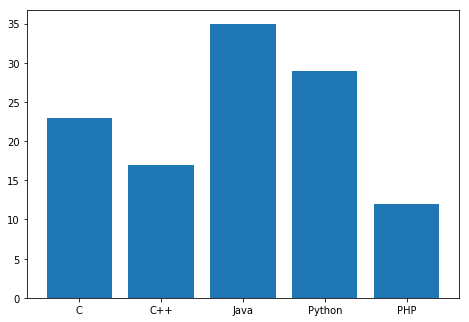

RuntimeError: Latex command not found. Install 'xelatex' or change pgf.texsystem to the desired command.

<Figure size 432x288 with 0 Axes>

In [330]:
apple = [52, 0.17, 0.26, 13.81] 
broccoli =  [34, 0.37, 2.82, 6.64]
icecrea =  [216, 11,3.8, 28.2]
rasp_slice = [418.26, 16.8, 1.7, 64.1]
sweetandsour = [194, 8.31, 11.6, 18.09]
timtam= [521.0, 26.9, 4.5, 64.4]
turkish= [256, 17, 20.1, 6]
cereal=[370.45, 0.6, 21.2, 66.4]
muffin=[236.7, 5.9, 8.9, 36.6]
tuna_pasta= [201, 9.9, 6.76, 20.86]

In [331]:
foodNotIn = [meanDifference(apple)]

In [332]:
foodNotIn.append(meanDifference(broccoli))
foodNotIn.append(meanDifference(icecrea))
foodNotIn.append(meanDifference(rasp_slice))
foodNotIn.append(meanDifference(sweetandsour))
foodNotIn.append(meanDifference(timtam))
foodNotIn.append(meanDifference(turkish))
foodNotIn.append(meanDifference(cereal))
foodNotIn.append(meanDifference(muffin))
foodNotIn.append(meanDifference(tuna_pasta))

In [340]:
foodNotIn

[[100.19999999999999, 7.43, 7.9399999999999995, 1.7899999999999991],
 [118.19999999999999, 7.2299999999999995, 5.379999999999999, 8.96],
 [63.80000000000001, 3.4000000000000004, 4.3999999999999995, 12.6],
 [266.06, 9.200000000000001, 6.499999999999999, 48.49999999999999],
 [41.80000000000001, 0.7100000000000009, 3.4000000000000004, 2.49],
 [368.8, 19.299999999999997, 3.6999999999999993, 48.800000000000004],
 [103.80000000000001, 9.4, 11.900000000000002, 9.6],
 [218.25, 7.0, 13.0, 50.800000000000004],
 [84.5, 1.6999999999999993, 0.7000000000000011, 21.0],
 [48.80000000000001, 2.3000000000000007, 1.4399999999999995, 5.26]]

In [329]:
def meanDifference(food):
    mean = [152.2,7.6,8.2,15.6]
    return [food - mean for food,mean in zip(food, mean)]


In [335]:
for i in range(10):
    for j in range(4):
        foodNotIn[i][j] =abs(foodNotIn[i][j])

In [344]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
min_max_scaler = MinMaxScaler()
fliptrans = min_max_scaler.fit_transform(foodNotIn)

In [345]:
fliptrans

array([[0.17859327, 0.36148467, 0.58861789, 0.        ],
       [0.23363914, 0.3507262 , 0.3804878 , 0.14629667],
       [0.06727829, 0.14470145, 0.30081301, 0.22056723],
       [0.6858104 , 0.45669715, 0.47154472, 0.9530708 ],
       [0.        , 0.        , 0.2195122 , 0.0142828 ],
       [1.        , 1.        , 0.24390244, 0.959192  ],
       [0.18960245, 0.46745562, 0.91056911, 0.15935523],
       [0.53960245, 0.33835395, 1.        , 1.        ],
       [0.13058104, 0.05325444, 0.        , 0.39196082],
       [0.02140673, 0.08552985, 0.0601626 , 0.07080188]])

In [346]:
flip = [] 
for j in range(4):
    temp = []
    for i in range(10):
        temp.append(fliptrans[i][j])
    flip.append(temp)

[[0.17859327217125376,
  0.2336391437308868,
  0.06727828746177372,
  0.6858103975535168,
  0.0,
  1.0,
  0.18960244648318042,
  0.5396024464831805,
  0.13058103975535168,
  0.021406727828746197],
 [0.36148466917697686,
  0.35072619688004303,
  0.1447014523937601,
  0.45669714900484143,
  0.0,
  1.0,
  0.46745562130177526,
  0.33835395373856914,
  0.05325443786982241,
  0.08552985476062401],
 [0.5886178861788618,
  0.3804878048780487,
  0.3008130081300812,
  0.4715447154471544,
  0.2195121951219512,
  0.24390243902439013,
  0.9105691056910571,
  1.0,
  0.0,
  0.060162601626016145],
 [0.0,
  0.14629667414813302,
  0.22056723117731075,
  0.9530708018771676,
  0.014282799428688042,
  0.9591920016323199,
  0.15935523362579063,
  0.9999999999999999,
  0.391960824321567,
  0.07080187716792491]]

In [348]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [370]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

/home/jwf5/venv/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


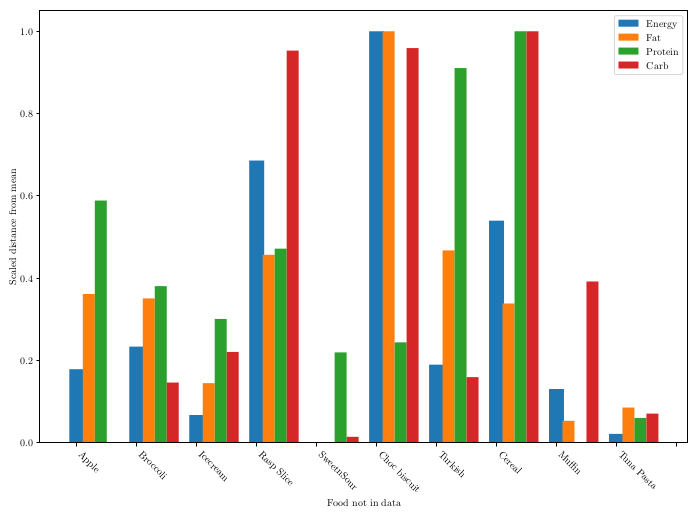

In [380]:

X = np.arange(10)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
labels = ["" ,"Apple", "Broccoli", "Icecream", "Rasp Slice", "SweetnSour", "Choc biscuit", "Turkish", "Cereal", "Muffin", "Tuna Pasta"] 
# students = [23,17,35,29,12]
ax.bar(X , flip[0], width = 0.25, label="Energy")
ax.bar(X + 0.2 , flip[1], width = 0.2, label = "Fat")
ax.bar(X + 0.4, flip[2], width = 0.2, label = "Protein")
ax.bar(X +0.6 , flip[3], width = 0.2, label= "Carb")
ax.set_xticklabels(labels)
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.legend()
plt.xlabel("Food not in data")
plt.ylabel("Scaled distance from mean")
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left" )
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
# ax.set_title('Distance from Mean')
# plt.show()
plt.tight_layout()
plt.savefig('DistanceFromMean.pgf')